<a href="https://colab.research.google.com/github/palit-ishan/IE_7374_Project/blob/master/ML_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving bank-full.csv to bank-full.csv


In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
df_bank_full = pd.read_csv('bank-full.csv',sep = ';')

In [4]:
df_bank_full.shape

(45211, 17)

Input variables:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Output variable (desired target):
21. y. has the client subscribed a term deposit? (binary: 'yes','no')

According to the dataset documentation, we need to remove the 'duration' column because in real-case the duration is only known after the label column is known. This problem can be considered to be 'data leakage' where predictors include data that will not be available at the time you make predictions.


In [5]:
# Checking null values in dataset
df_bank_full.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No Null Values are there in the dataset


In [6]:
# Drop 'duration' column
df_bank_full = df_bank_full.drop('duration', axis=1)

Dropping the duration field as the duration will only be recorded after the completion of the marketing call


In [7]:
# Splitting the full data into test and train data to avoid inherent biases in models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_bank_full.iloc[:,0:-1],df_bank_full.iloc[:,-1] , test_size=0.2, random_state=42)

In [8]:
# A merged dataframe of the train set - input and output & test set - input and output 
df_bank_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
df_bank_test = pd.merge(X_test,y_test,left_index = True, right_index = True)

In [9]:
# Renaming output column to 'deposit'
df_bank_ready_train = df_bank_train.rename(columns = {'y':'deposit'})
df_bank_ready_test = df_bank_test.rename(columns = {'y':'deposit'})


In [10]:
df_bank_ready_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
3344,41,blue-collar,married,primary,no,849,yes,no,unknown,15,may,1,-1,0,unknown,no
17965,49,technician,married,primary,no,1415,yes,no,cellular,30,jul,2,-1,0,unknown,no
18299,42,admin.,married,secondary,no,3842,no,no,cellular,31,jul,4,-1,0,unknown,no
10221,37,management,single,tertiary,no,-119,yes,no,unknown,11,jun,11,-1,0,unknown,no
32192,56,blue-collar,married,primary,no,3498,no,no,cellular,15,apr,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,housemaid,single,primary,no,1059,no,no,unknown,18,jun,1,-1,0,unknown,yes
44732,23,student,single,tertiary,no,508,no,no,cellular,8,sep,1,92,1,failure,no
38158,34,technician,divorced,tertiary,no,1317,yes,no,cellular,15,may,1,-1,0,unknown,no
860,33,retired,married,secondary,no,165,no,no,unknown,7,may,1,-1,0,unknown,no


In [11]:
df_bank_ready_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'deposit'],
      dtype='object')

In [12]:
y_train.value_counts()

no     31970
yes     4198
Name: y, dtype: int64

In [13]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numerical = [x for x in df_bank_ready_train.columns.to_list() if x not in categorical]
numerical.remove('deposit')

There is class imbalance in the dataset - the number of no's are almost 8x the number of yes

Text(0, 0.5, 'Class')

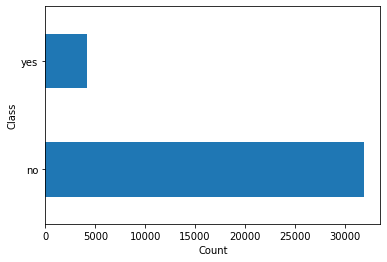

In [14]:
# Plotting Bar Charts for Yes/No counts 
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Class')

Conclusion - Our dataset is highly imbalanced towards No
From a general idea about marketing campaigns we can state that - a customer will be more likely to say No to the term deposit call



**job**

In [15]:
#Analysing Job categories
df_bank_ready_train['job'].value_counts()

blue-collar      7806
management       7500
technician       6096
admin.           4137
services         3350
retired          1815
self-employed    1286
entrepreneur     1178
unemployed       1023
housemaid        1002
student           742
unknown           233
Name: job, dtype: int64

Text(0, 0.5, 'Job')

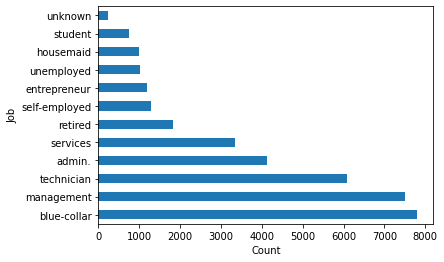

In [16]:
#Analysing Job categories
df_bank_ready_train['job'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Job')

Text(0.5, 1.0, 'Count Plot of job for target variable')

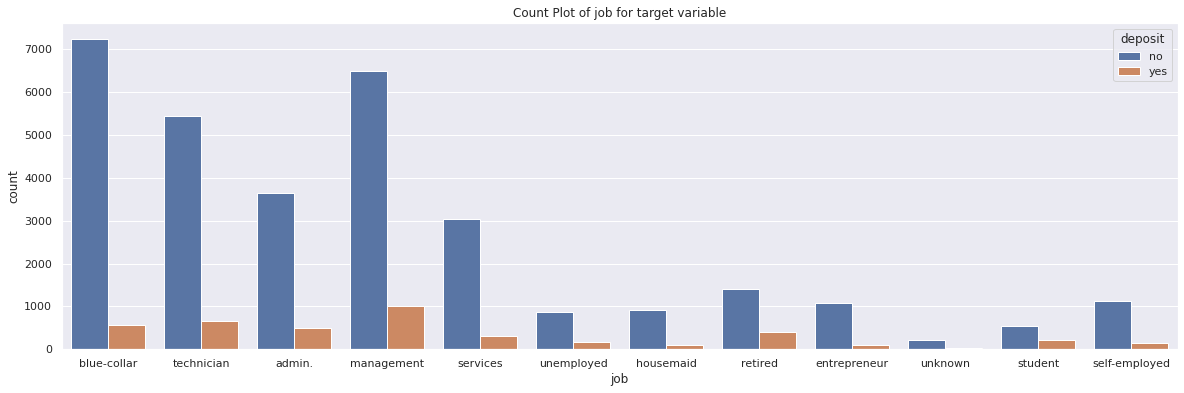

In [17]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,6)})
sns.countplot(x=df_bank_ready_train['job'], data=df_bank_ready_train, hue=df_bank_ready_train['deposit'])
plt.title('Count Plot of job for target variable')

In [18]:
import prettytable as pt
table = pt.PrettyTable(['Job', 'Total Clients', 'Success rate'])
table.add_row(['Blue-collar', len(df_bank_ready_train[df_bank_ready_train['job'] == 'blue-collar']), df_bank_ready_train[df_bank_ready_train['job'] == 'blue-collar'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'blue-collar'])])
table.add_row(['Management', len(df_bank_ready_train[df_bank_ready_train['job'] == 'management']), df_bank_ready_train[df_bank_ready_train['job'] == 'management'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'management'])])
table.add_row(['Technician', len(df_bank_ready_train[df_bank_ready_train['job'] == 'technician']), df_bank_ready_train[df_bank_ready_train['job'] == 'technician'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'technician'])])
table.add_row(['Admin', len(df_bank_ready_train[df_bank_ready_train['job'] == 'admin.']), df_bank_ready_train[df_bank_ready_train['job'] == 'admin.'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'admin.'])])
table.add_row(['Services', len(df_bank_ready_train[df_bank_ready_train['job'] == 'services']), df_bank_ready_train[df_bank_ready_train['job'] == 'services'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'services'])])
table.add_row(['Retired', len(df_bank_ready_train[df_bank_ready_train['job'] == 'retired']), df_bank_ready_train[df_bank_ready_train['job'] == 'retired'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'retired'])])
table.add_row(['Self-employed', len(df_bank_ready_train[df_bank_ready_train['job'] == 'self-employed']), df_bank_ready_train[df_bank_ready_train['job'] == 'self-employed'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'self-employed'])])
table.add_row(['Entrepreneur', len(df_bank_ready_train[df_bank_ready_train['job'] == 'entrepreneur']), df_bank_ready_train[df_bank_ready_train['job'] == 'entrepreneur'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'entrepreneur'])])
table.add_row(['Unemployed', len(df_bank_ready_train[df_bank_ready_train['job'] == 'unemployed']), df_bank_ready_train[df_bank_ready_train['job'] == 'unemployed'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'unemployed'])])
table.add_row(['Housemaid', len(df_bank_ready_train[df_bank_ready_train['job'] == 'housemaid']), df_bank_ready_train[df_bank_ready_train['job'] == 'housemaid'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'housemaid'])])
table.add_row(['Student', len(df_bank_ready_train[df_bank_ready_train['job'] == 'student']), df_bank_ready_train[df_bank_ready_train['job'] == 'student'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'student'])])
table.add_row(['Unknown', len(df_bank_ready_train[df_bank_ready_train['job'] == 'unknown']), df_bank_ready_train[df_bank_ready_train['job'] == 'unknown'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['job'] == 'unknown'])])
print(table)

+---------------+---------------+---------------------+
|      Job      | Total Clients |     Success rate    |
+---------------+---------------+---------------------+
|  Blue-collar  |      7806     |  0.0722521137586472 |
|   Management  |      7500     | 0.13546666666666668 |
|   Technician  |      6096     | 0.10875984251968504 |
|     Admin     |      4137     | 0.11989364273628234 |
|    Services   |      3350     | 0.09074626865671642 |
|    Retired    |      1815     | 0.22258953168044077 |
| Self-employed |      1286     | 0.12286158631415241 |
|  Entrepreneur |      1178     |  0.0865874363327674 |
|   Unemployed  |      1023     |  0.1603128054740958 |
|   Housemaid   |      1002     | 0.09381237524950099 |
|    Student    |      742      | 0.27897574123989216 |
|    Unknown    |      233      | 0.11158798283261803 |
+---------------+---------------+---------------------+


__Observation:__  
* Top contacted clients are from job type: 'blue-collar', 'management' & 'technician'
* Success rate is highest for student followed by retired people


Text(0, 0.5, 'Marital')

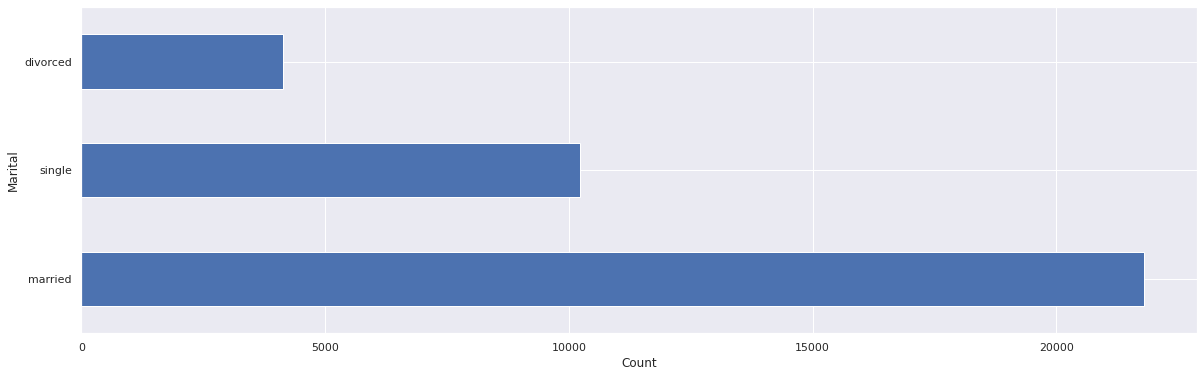

In [19]:
#Analysing Marital categories
X_train['marital'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Marital')

**education**

In [20]:
df_bank_ready_train.education.value_counts()

secondary    18670
tertiary     10539
primary       5476
unknown       1483
Name: education, dtype: int64

Text(0, 0.5, 'Education')

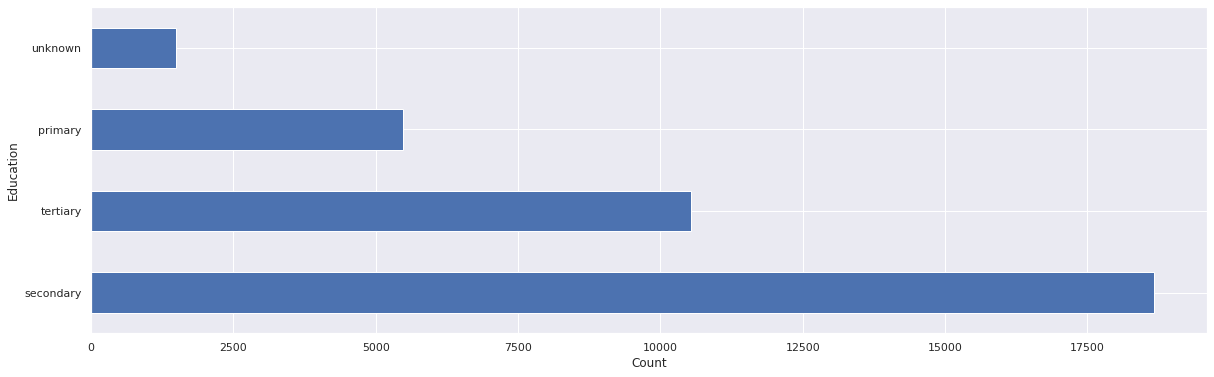

In [21]:
#Analysing education categories
df_bank_ready_train['education'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Education')

Text(0.5, 1.0, 'Count plot of education for target variable y')

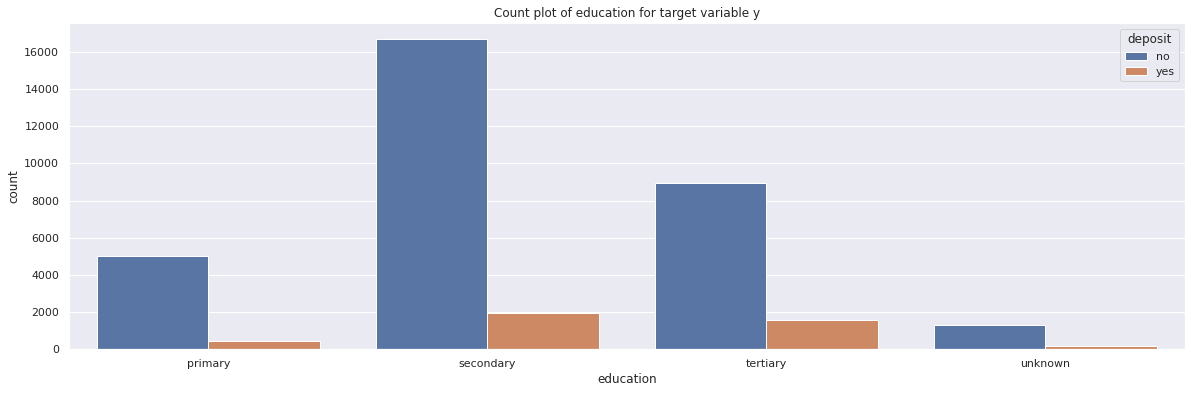

In [22]:
sns.countplot(x=df_bank_ready_train['education'], data=df_bank_ready_train, hue=df_bank_ready_train['deposit'])
plt.title('Count plot of education for target variable y')

__Observation:__
* Most of the people who are contacted have tertiray or secondary education.

default

In [23]:
df_bank_ready_train.default.value_counts()

no     35491
yes      677
Name: default, dtype: int64

Text(0.5, 1.0, 'Count plot of default for target variable y')

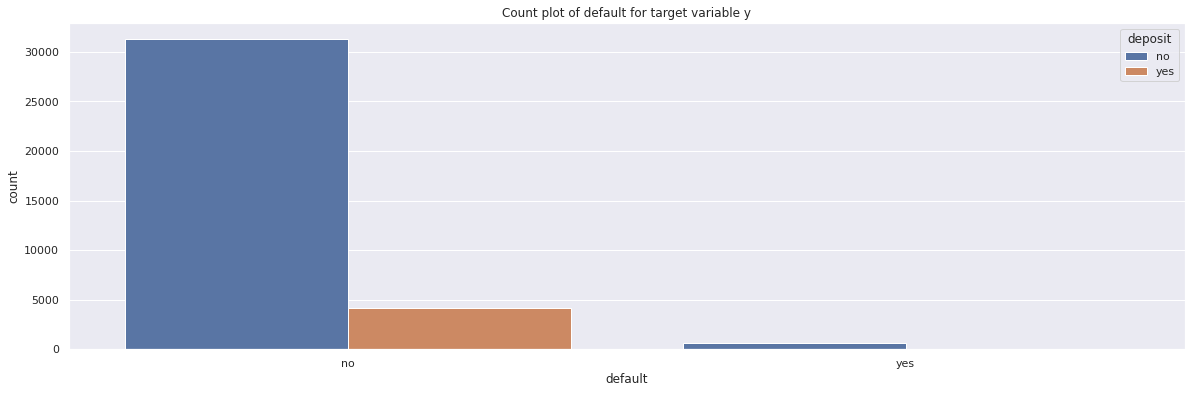

In [24]:
sns.countplot(x=df_bank_ready_train['default'], data=df_bank_ready_train, hue=df_bank_ready_train['deposit'])
plt.title('Count plot of default for target variable y')

In [25]:
df_bank_ready_train[df_bank_ready_train['default'] == 'yes'].deposit.count()

677

__Observation:__  
Very few clients are contacted who are defaulter.

**poutcome**

In [26]:
df_bank_ready_train.poutcome.value_counts()

unknown    29560
failure     3901
other       1497
success     1210
Name: poutcome, dtype: int64

Text(0, 0.5, 'Outcome of the previous marketing campaign')

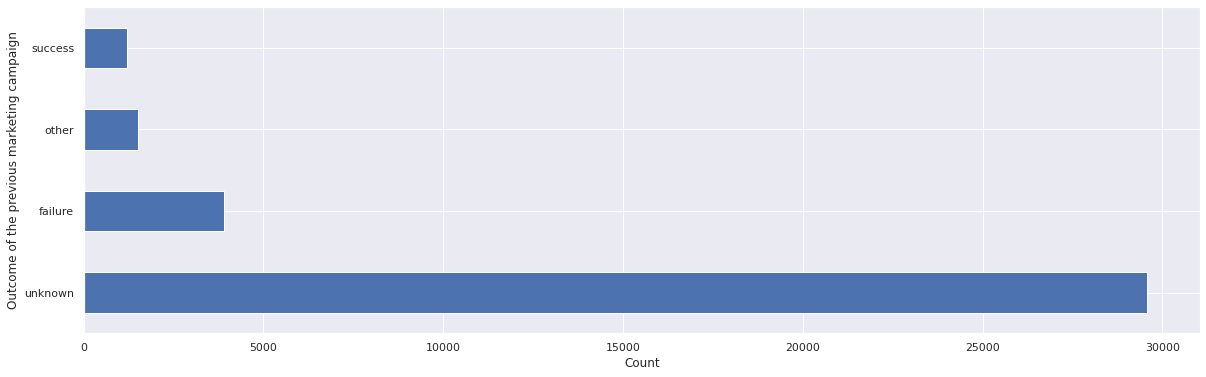

In [27]:
#Analysing Outcome of the previous marketing campaign  categories
df_bank_ready_train['poutcome'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Outcome of the previous marketing campaign')

Text(0.5, 1.0, 'Count Plot of poutcome for target variable')

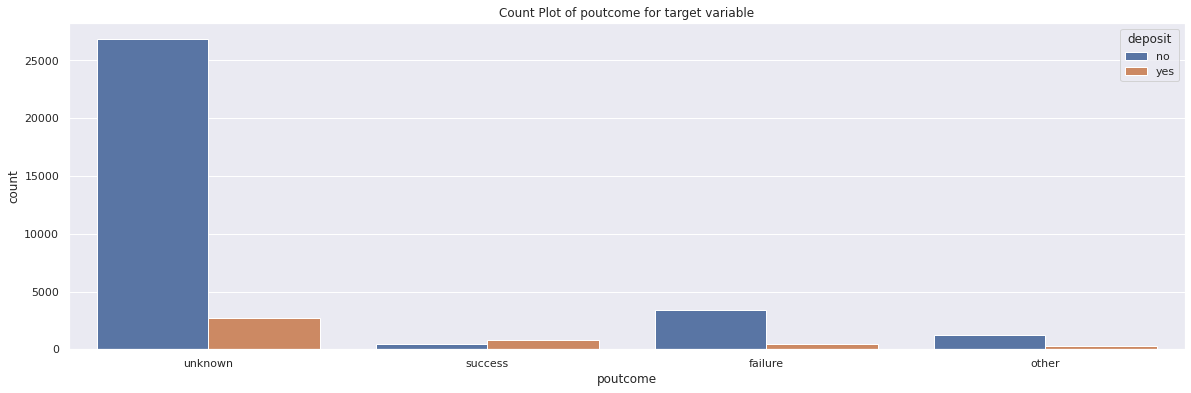

In [28]:
sns.countplot(x=df_bank_ready_train['poutcome'], data=df_bank_ready_train, hue=df_bank_ready_train['deposit'])
plt.title('Count Plot of poutcome for target variable')

__Observation:__
* Most of the clients contacted have previous outcome as 'unknown'.

**PDays**

Text(0.5, 0, 'y: target variable')

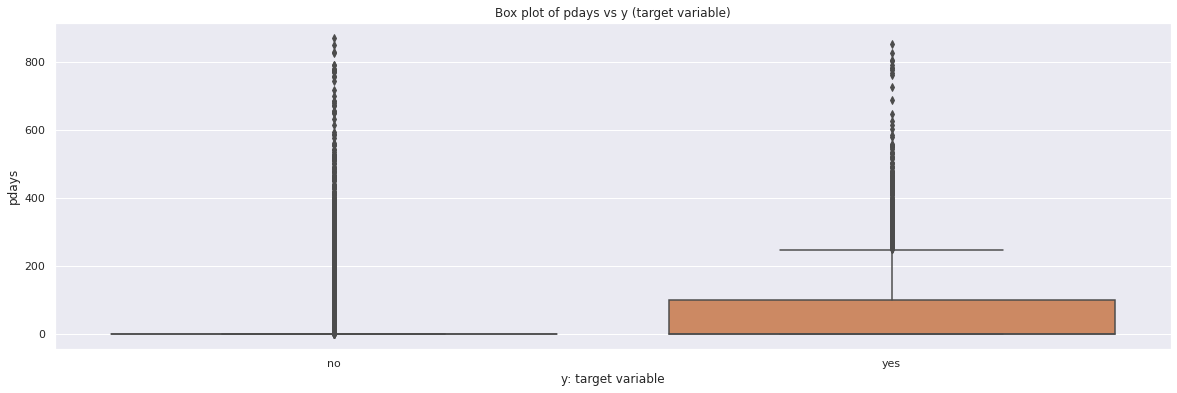

In [29]:
# Analysing p days
import seaborn as sns
sns.boxplot(y=df_bank_ready_train['pdays'], x=df_bank_ready_train['deposit'])
plt.title('Box plot of pdays vs y (target variable)')
plt.xlabel('y: target variable')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PDF of pdays for target variable y')

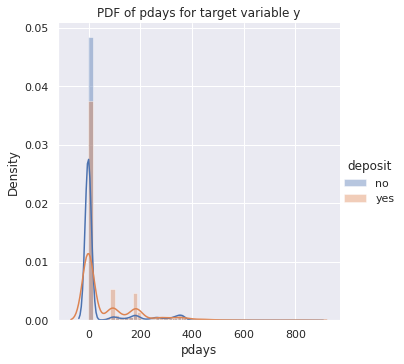

In [30]:
# PDF of pdays for the target variable - y
sns.FacetGrid(df_bank_ready_train, hue='deposit', size=5).map(sns.distplot, 'pdays').add_legend()
plt.title('PDF of pdays for target variable y')

In [31]:
df_bank_ready_train.pdays.describe()

count    36168.000000
mean        40.180076
std        100.107617
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

In [32]:
for x in range(95, 101 , 1):
    print("{}% of pdays are less than equal to {}".format(x, df_bank_ready_train.pdays.quantile(x/100)))
iqr = df_bank_ready_train.pdays.quantile(0.75) - df_bank_ready_train.pdays.quantile(0.25)
print('IQR {}'.format(iqr))

95% of pdays are less than equal to 316.65000000000146
96% of pdays are less than equal to 337.0
97% of pdays are less than equal to 349.0
98% of pdays are less than equal to 360.0
99% of pdays are less than equal to 370.0
100% of pdays are less than equal to 871.0
IQR 0.0


__Observation:__  
* The attribute pdays seems to be important feature as there is a clear distinction in quartile ranges of pdays for target variable yes and no.
* 75% clients contacted through campaign are not previously contacted.
* Mean of pdays is 40.18
* There are outliers as we can see from boxplot.


**previous**

Text(0.5, 0, 'y:target variable')

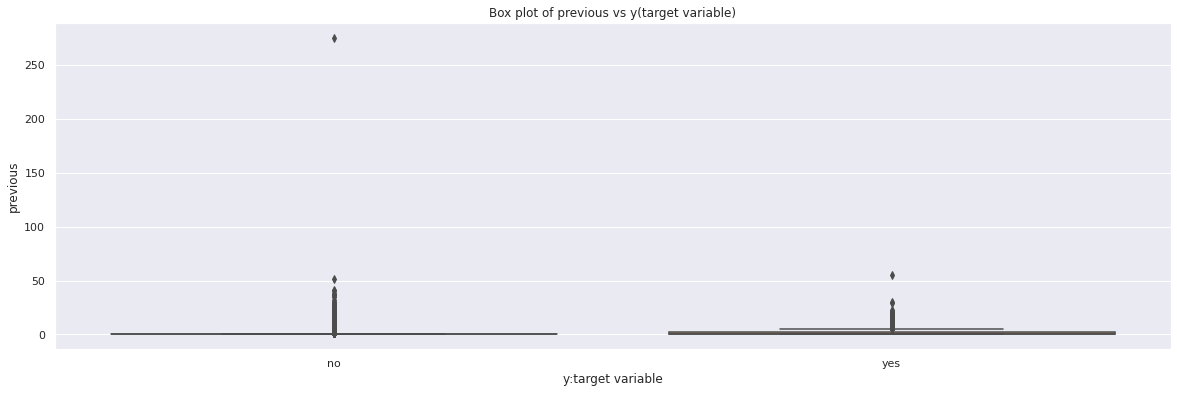

In [33]:
sns.boxplot(y=df_bank_ready_train['previous'], x=df_bank_ready_train['deposit'])
plt.title('Box plot of previous vs y(target variable)')
plt.xlabel('y:target variable')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PDF of previous values for target variable y')

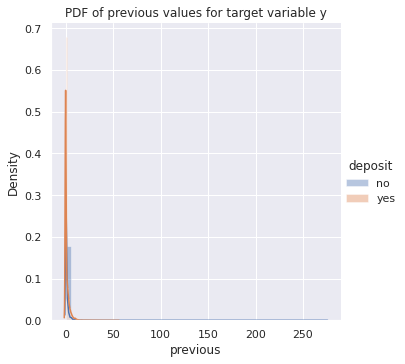

In [34]:
sns.FacetGrid(df_bank_ready_train, hue='deposit', size=5).map(sns.distplot, 'previous').add_legend()
plt.title('PDF of previous values for target variable y')

In [35]:
df_bank_ready_train.previous.describe()

count    36168.000000
mean         0.580264
std          2.370668
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

In [36]:
for x in range(95, 101 , 1):
    print("{}% of previous values less than equal to {}".format(x, df_bank_ready_train.previous.quantile(x/100)))
iqr = df_bank_ready_train.previous.quantile(0.75) - df_bank_ready_train.previous.quantile(0.25)
print('IQR {}'.format(iqr))

95% of previous values less than equal to 3.0
96% of previous values less than equal to 4.0
97% of previous values less than equal to 5.0
98% of previous values less than equal to 6.0
99% of previous values less than equal to 8.0
100% of previous values less than equal to 275.0
IQR 0.0


__Observation:__  
* 75% of previous values equal 0 and 99% values <= 8.0
* duration have a mean of 0.58 and standard-deviation 2.37
* There are outliers points in duration.


**age**

Text(0.5, 0, 'y:target variable')

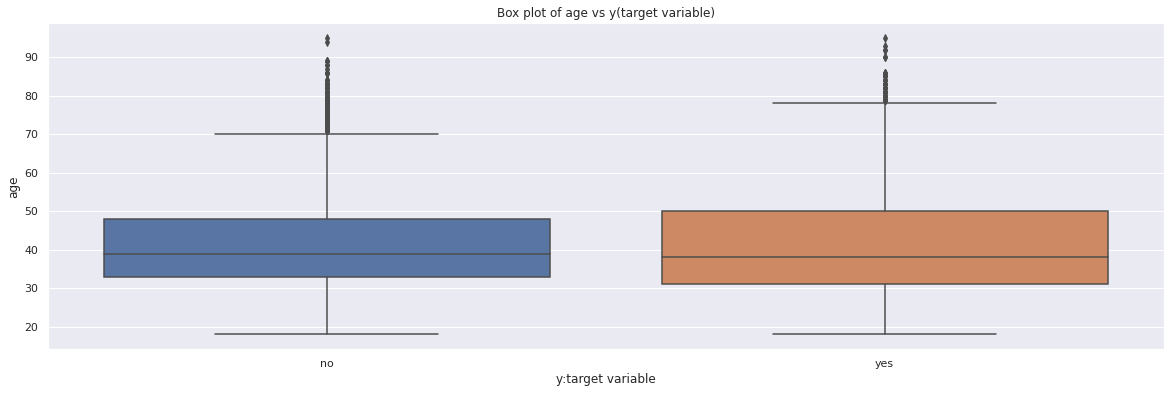

In [37]:
sns.boxplot(y=df_bank_ready_train['age'], x=df_bank_ready_train['deposit'])
plt.title('Box plot of age vs y(target variable)')
plt.xlabel('y:target variable')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PDF of age for target variable y')

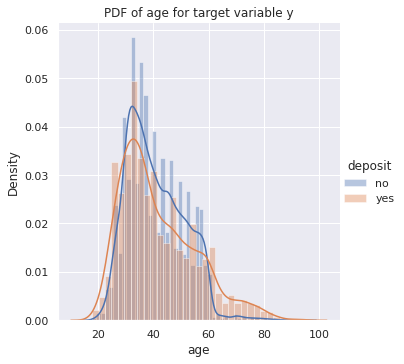

In [38]:
sns.FacetGrid(df_bank_ready_train, hue='deposit', size=5).map(sns.distplot, 'age').add_legend()
plt.title('PDF of age for target variable y')

In [39]:
df_bank_ready_train.age.describe()

count    36168.000000
mean        40.930823
std         10.618369
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

In [40]:
for x in range(95, 101 , 1):
    print("{}% of people having age are less than equal to {}".format(x, df_bank_ready_train.age.quantile(x/100)))
iqr = df_bank_ready_train.age.quantile(0.75) - df_bank_ready_train.age.quantile(0.25)
print('IQR {}'.format(iqr))

95% of people having age are less than equal to 59.0
96% of people having age are less than equal to 59.0
97% of people having age are less than equal to 60.0
98% of people having age are less than equal to 63.0
99% of people having age are less than equal to 71.0
100% of people having age are less than equal to 95.0
IQR 15.0


In [41]:
lst = [df_bank_ready_train]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] < 40), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] < 50), 'age_group'] = 40
    column.loc[(column["age"] >= 45) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60

In [42]:
count_age_response_pct = pd.crosstab(df_bank_ready_train['deposit'],df_bank_ready_train['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose()

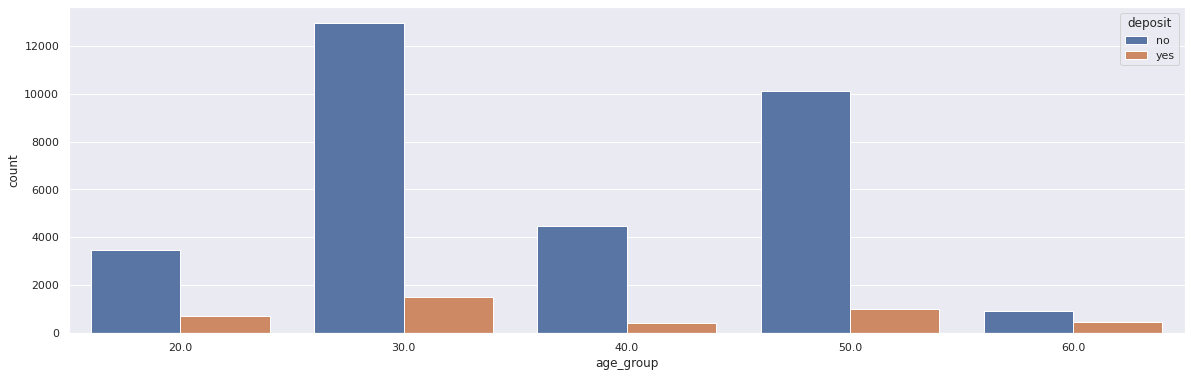

In [43]:
sns.countplot(x='age_group', data=df_bank_ready_train, hue='deposit')

In [44]:
print('Success rate and total clients contacted for different age_groups:')
print('Clients age < 30 contacted: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['age_group'] == 20]), df_bank_ready_train[df_bank_ready_train['age_group'] == 20].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['age_group'] == 20])))
print('Clients of age 30-39 contacted: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['age_group'] == 30]), df_bank_ready_train[df_bank_ready_train['age_group'] == 30].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['age_group'] == 30])))
print('Clients of age 40-49 contacted: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['age_group'] == 40]), df_bank_ready_train[df_bank_ready_train['age_group'] == 40].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['age_group'] == 40])))
print('Clients of age 50-59 contacted: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['age_group'] == 50]), df_bank_ready_train[df_bank_ready_train['age_group'] == 50].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['age_group'] == 50])))
print('Clients of 60+ age contacted: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['age_group'] == 60]), df_bank_ready_train[df_bank_ready_train['age_group'] == 60].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['age_group'] == 60])))

Success rate and total clients contacted for different age_groups:
Clients age < 30 contacted: 4226, Success rate: 0.17415996213913867
Clients of age 30-39 contacted: 14478, Success rate: 0.10498687664041995
Clients of age 40-49 contacted: 4913, Success rate: 0.08833706492977814
Clients of age 50-59 contacted: 11130, Success rate: 0.09209344115004492
Clients of 60+ age contacted: 1421, Success rate: 0.3399014778325123


__Observation:__  
* People with age < 30 or 60+ have higher success rate.This corroborates with our earlier analysis that students (usually below 30) and retired(60+) have highest success rates.
* Only 3% of clients have age of 60+ 


loan

In [45]:
df_bank_ready_train.loan.value_counts()

no     30333
yes     5835
Name: loan, dtype: int64

Text(0.5, 1.0, 'Count plot of loan for target variable y')

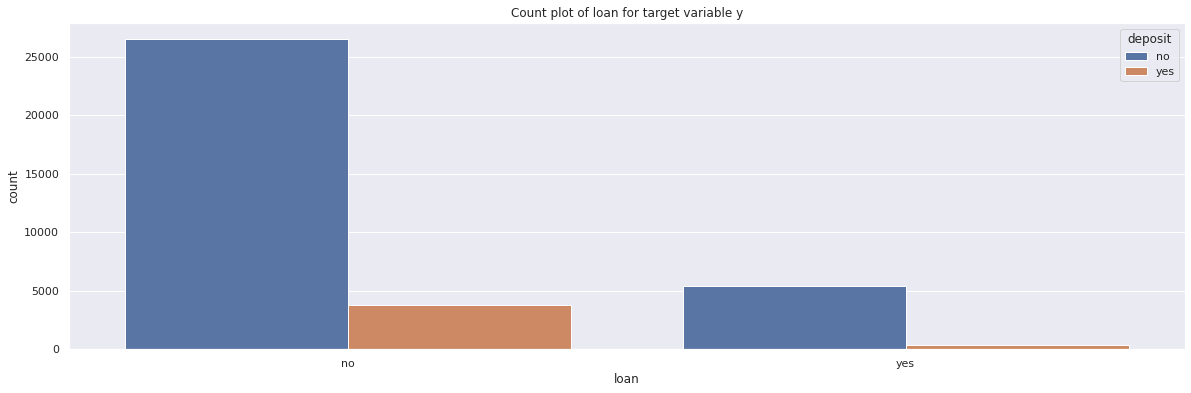

In [46]:
sns.countplot(x=df_bank_ready_train['loan'], data=df_bank_ready_train, hue=df_bank_ready_train['deposit'])
plt.title('Count plot of loan for target variable y')

__Observation:__  
* As seen for default variable, less client are contacted who have loan.

contact

In [47]:
df_bank_ready_train.contact.value_counts()

cellular     23464
unknown      10385
telephone     2319
Name: contact, dtype: int64

Text(0.5, 1.0, 'Count plot of contact for target variable deposit')

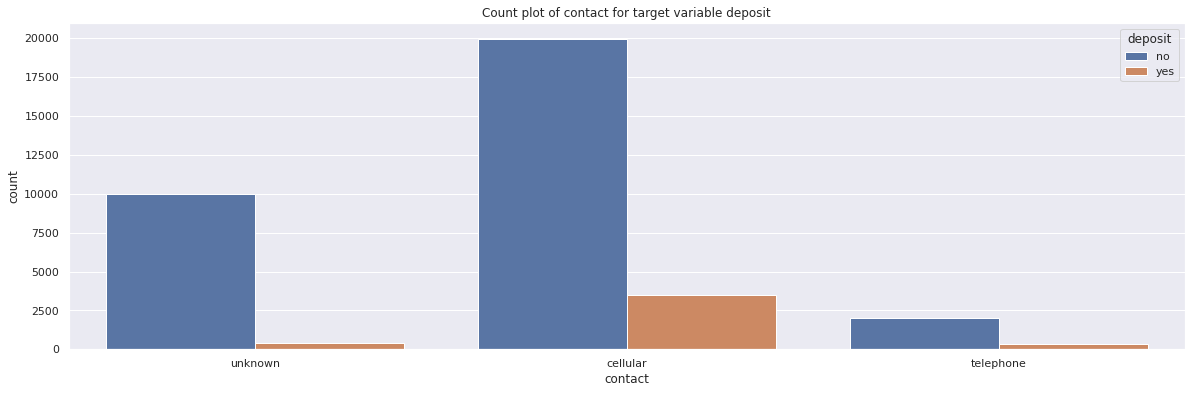

In [48]:
sns.countplot(x=df_bank_ready_train['contact'], data=df_bank_ready_train, hue=df_bank_ready_train['deposit'])
plt.title('Count plot of contact for target variable deposit')

__Observation:__  
Most of the people are contacted through cellular

**month**

In [49]:
df_bank_ready_train.month.value_counts()

may    10963
jul     5537
aug     4966
jun     4318
nov     3173
apr     2344
feb     2112
jan     1135
oct      599
sep      464
mar      374
dec      183
Name: month, dtype: int64

Text(0.5, 1.0, 'Count plot of month for target variable y')

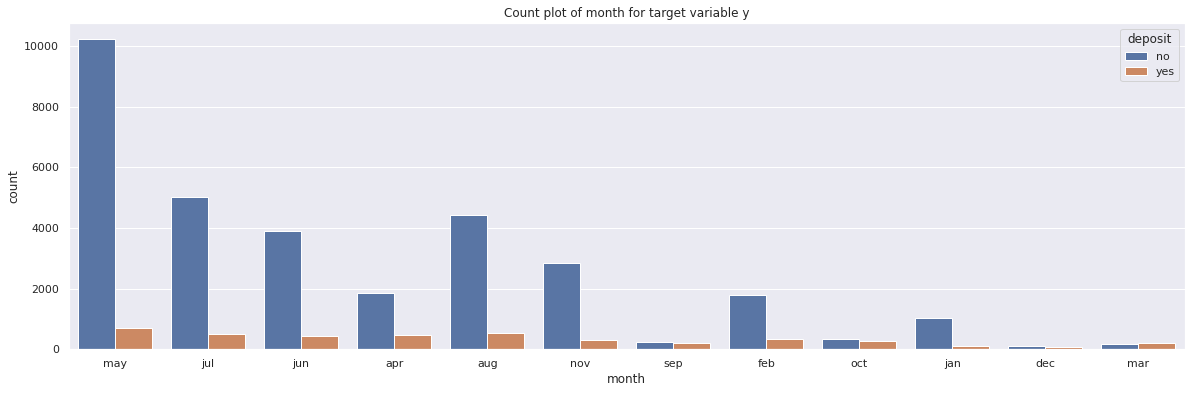

In [50]:
sns.countplot(x=df_bank_ready_train['month'], data=df_bank_ready_train, hue=df_bank_ready_train['deposit'])
plt.title('Count plot of month for target variable y')

In [51]:
df_bank_ready_train[df_bank_ready_train['month'] == 'jan'].deposit.value_counts()

no     1023
yes     112
Name: deposit, dtype: int64

In [52]:
print('Success rate and total clients contacted for different months:')
print('Clients contacted in January: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'jan']), df_bank_ready_train[df_bank_ready_train['month'] == 'jan'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'jan'])))
print('Clients contacted in February: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'feb']), df_bank_ready_train[df_bank_ready_train['month'] == 'feb'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'feb'])))
print('Clients contacted in March: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'mar']), df_bank_ready_train[df_bank_ready_train['month'] == 'mar'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'mar'])))
print('Clients contacted in April: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'apr']), df_bank_ready_train[df_bank_ready_train['month'] == 'apr'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'apr'])))
print('Clients contacted in May: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'may']), df_bank_ready_train[df_bank_ready_train['month'] == 'may'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'may'])))
print('Clients contacted in June: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'jun']), df_bank_ready_train[df_bank_ready_train['month'] == 'jun'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'jun'])))
print('Clients contacted in July: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'jul']), df_bank_ready_train[df_bank_ready_train['month'] == 'jul'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'jul'])))
print('Clients contacted in August: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'aug']), df_bank_ready_train[df_bank_ready_train['month'] == 'aug'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'aug'])))
print('Clients contacted in September: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'sep']), df_bank_ready_train[df_bank_ready_train['month'] == 'sep'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'sep'])))
print('Clients contacted in October: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'oct']), df_bank_ready_train[df_bank_ready_train['month'] == 'oct'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'oct'])))
print('Clients contacted in November: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'nov']), df_bank_ready_train[df_bank_ready_train['month'] == 'nov'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'nov'])))
print('Clients contacted in December: {}, Success rate: {}'.format(len(df_bank_ready_train[df_bank_ready_train['month'] == 'dec']), df_bank_ready_train[df_bank_ready_train['month'] == 'dec'].deposit.value_counts()[1]/len(df_bank_ready_train[df_bank_ready_train['month'] == 'dec'])))

Success rate and total clients contacted for different months:
Clients contacted in January: 1135, Success rate: 0.0986784140969163
Clients contacted in February: 2112, Success rate: 0.15672348484848486
Clients contacted in March: 374, Success rate: 0.4839572192513369
Clients contacted in April: 2344, Success rate: 0.20264505119453924
Clients contacted in May: 10963, Success rate: 0.06521937425887074
Clients contacted in June: 4318, Success rate: 0.09888837424733674
Clients contacted in July: 5537, Success rate: 0.09192703630124616
Clients contacted in August: 4966, Success rate: 0.11095449053564237
Clients contacted in September: 464, Success rate: 0.46551724137931033
Clients contacted in October: 599, Success rate: 0.4373956594323873
Clients contacted in November: 3173, Success rate: 0.10148124803025528
Clients contacted in December: 183, Success rate: 0.4644808743169399


__Observation:__
* Most of the clients (approx 1/3 of total) are contacted in the month of May but the success rate is only 6.7%.
* March have highest success rate.

**Pairplot**

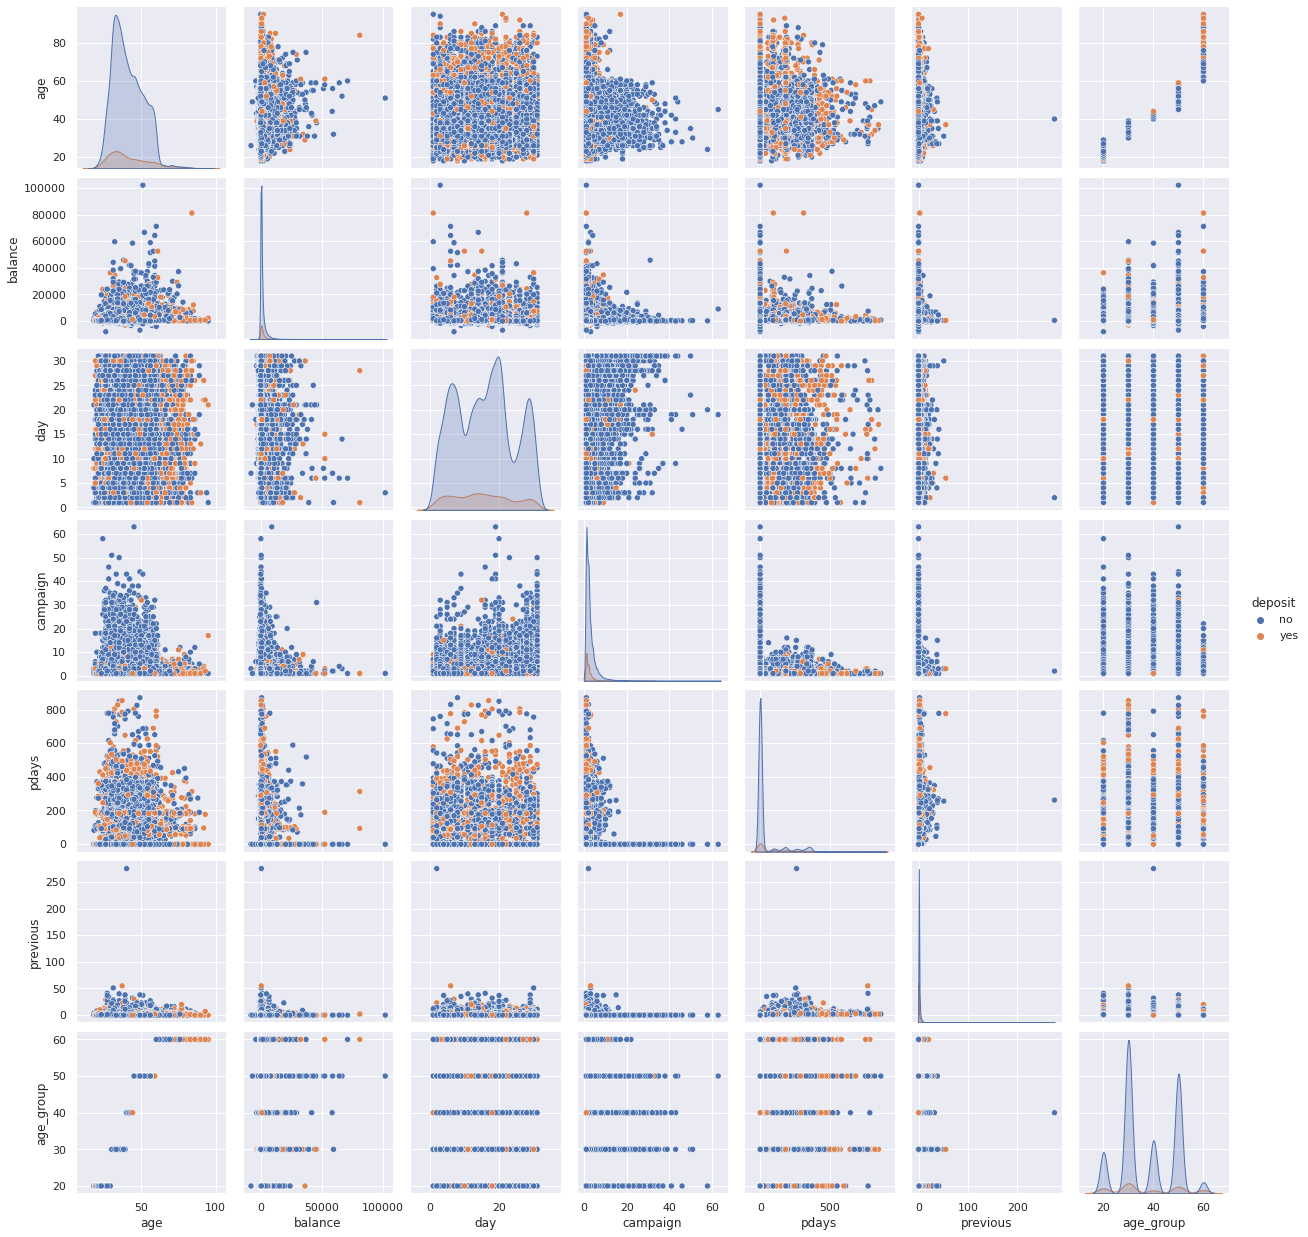

In [53]:
#data.drop('age_group', axis=1, inplace=True)
sns.pairplot(df_bank_ready_train, hue='deposit')

__Observation:__  
* For most of the variables our pair plot is overlapping a lot.
* Pair plots of age-campaign and day-campaign are efficient in distinguishing between different classes with very few overlapes.

Univariate Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fb3cb8e90>,
      dtype=object)

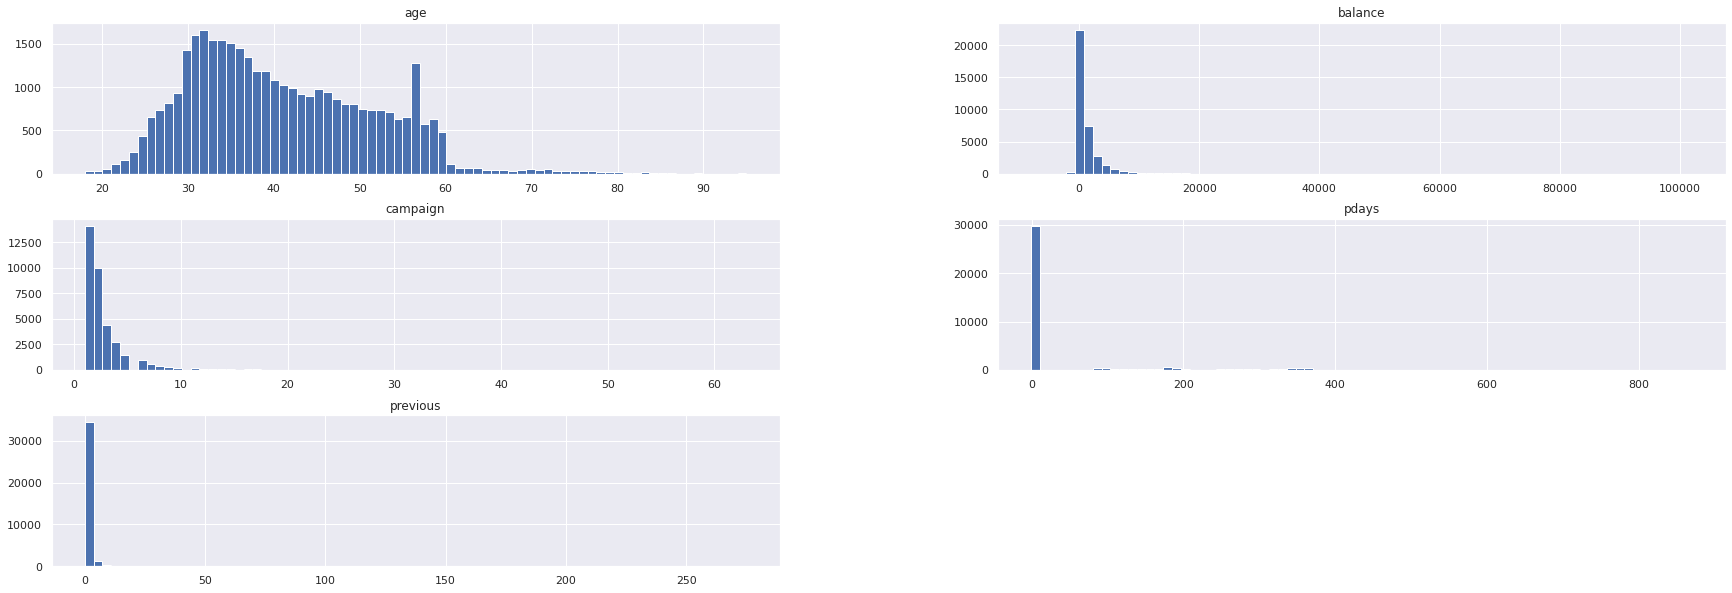

In [54]:
# Univariate Analysis
X_train.hist(column = ['age','balance','campaign','pdays','previous'],figsize = (30,10),bins = 75)

Encoded the target variable in both test and train set

In [55]:
# Encode target value
df_bank_ready_train['deposit'] = df_bank_ready_train['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_bank_ready_test['deposit'] = df_bank_ready_test['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

**Correlation matrix of numerical features**

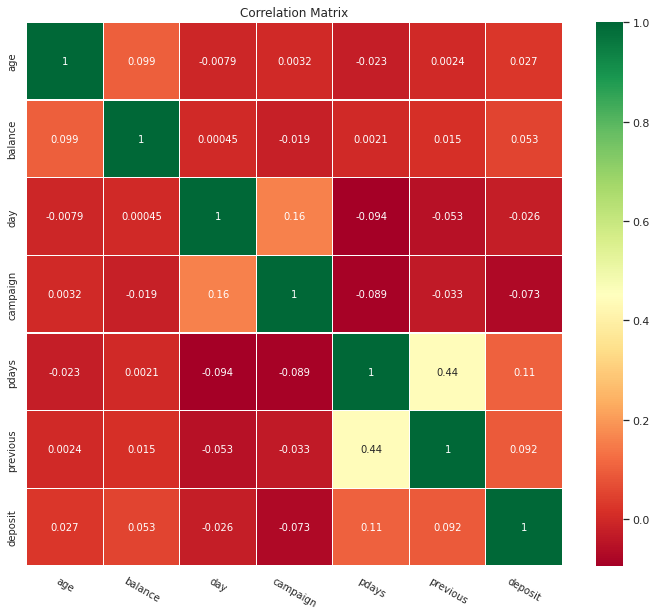

In [56]:
corr_data = df_bank_ready_train[numerical + ['deposit']]
corr = corr_data.corr()
plt.close()
cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

__Observation:__  
* Overall numerical features have very less correlation between them.
* pdays and previous have higher correlation.


### **Outlier detection for numerical attributes using IQR**

The concept of quartiles and IQR can best be visualized from the boxplot. It has the minimum and maximum point defined as Q1–1.5*IQR and Q3+1.5*IQR respectively. Any point outside this range is outlier.



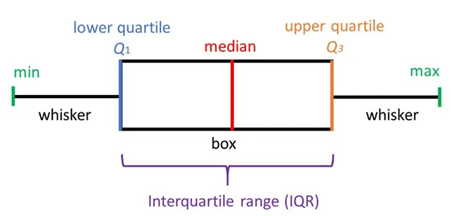

In [57]:
# creating new data frame of numerical columns 
data_numerical = df_bank_ready_train[numerical]
print('Shape of numerical dataframe {}'.format(data_numerical.shape))
data_numerical.head()

Shape of numerical dataframe (36168, 6)


,age,balance,day,campaign,pdays,previous
3344,41,849,15,1,-1,0
17965,49,1415,30,2,-1,0
18299,42,3842,31,4,-1,0
10221,37,-119,11,11,-1,0
32192,56,3498,15,2,-1,0


In [58]:
q3 = data_numerical.quantile(0.75)
q1 = data_numerical.quantile(0.25)
iqr = q3 - q1
print('IQR for numerical attributes')
print(iqr)

IQR for numerical attributes
age           15.0
balance     1359.0
day           13.0
campaign       2.0
pdays          0.0
previous       0.0
dtype: float64


In [59]:
data_out = df_bank_ready_train[~((data_numerical < (q1 - 1.5 * iqr)) |(data_numerical > (q3 + 1.5 * iqr))).any(axis=1)]
print('{} points are outliers based on IQR'.format(df_bank_ready_train.shape[0] - data_out.shape[0]))

11879 points are outliers based on IQR


In [60]:
df_bank_ready_train.shape

(36168, 17)

As seen above 11879 are Outliers based on inter-quartile range method of Outlier Detection.Almost 33% of the data falls under outliers, hence we cannot remove the data outright.

In [61]:
df_bank_ready_train = df_bank_ready_train.drop(columns = ['age_group'])

Scaling

We will scale our numerical data to avoid outlier presence that can significantly affect our model. Using `StandardScaler()` function from sklearn we can scale each our columns that contains numerical data. The scaling will be done using the formula below:

<div align="center">$Z = \frac{X - U}{S}$</div>

*Where:*

*$Z:$ scaled value*

*$X:$ original value*

*$U:$ mean of the data*

*$S:$ standard deviation of the data*



In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
df_bank_ready_train[num_cols] = scaler.fit_transform(df_bank_ready_train[num_cols])
# Using same scaler to transform the test set
df_bank_ready_test[num_cols] = scaler.transform(df_bank_ready_test[num_cols])
df_bank_ready_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
3344,0.006515,blue-collar,married,primary,no,-0.169381,yes,no,unknown,-0.098218,may,-0.565886,-0.411364,-0.244772,unknown,0
17965,0.759937,technician,married,primary,no,0.017848,yes,no,cellular,1.703422,jul,-0.245389,-0.411364,-0.244772,unknown,0
18299,0.100693,admin.,married,secondary,no,0.820681,no,no,cellular,1.823532,jul,0.395606,-0.411364,-0.244772,unknown,0
10221,-0.370196,management,single,tertiary,no,-0.489588,yes,no,unknown,-0.578656,jun,2.639088,-0.411364,-0.244772,unknown,0
32192,1.419181,blue-collar,married,primary,no,0.706889,no,no,cellular,-0.098218,apr,-0.245389,-0.411364,-0.244772,unknown,1


**Feature Importance**

Encoding Categorical values for Feature Importance Measurement.

In [63]:
data1 = df_bank_ready_train.copy()
data1['job'] = df_bank_ready_train['job'].astype('category').cat.codes
data1['marital'] = df_bank_ready_train['marital'].astype('category').cat.codes
data1['education'] = df_bank_ready_train['education'].astype('category').cat.codes
data1['contact'] = df_bank_ready_train['contact'].astype('category').cat.codes
data1['poutcome'] = df_bank_ready_train['poutcome'].astype('category').cat.codes
data1['month'] = df_bank_ready_train['month'].astype('category').cat.codes
data1['default'] = df_bank_ready_train['default'].astype('category').cat.codes
data1['loan'] = df_bank_ready_train['loan'].astype('category').cat.codes
data1['housing'] = df_bank_ready_train['housing'].astype('category').cat.codes

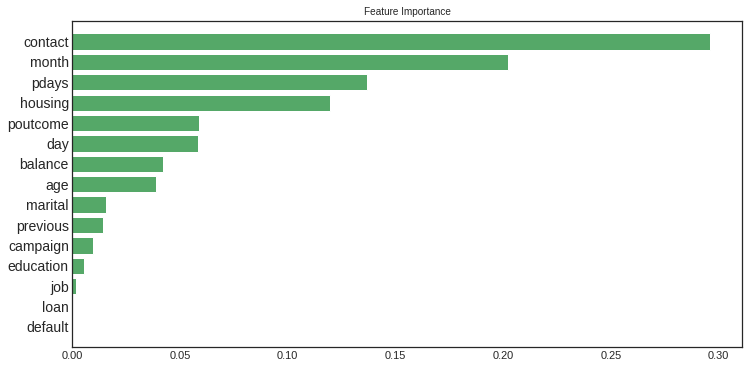

In [64]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import numpy as np
plt.style.use('seaborn-white')

clf = DecisionTreeClassifier(class_weight='balanced', min_weight_fraction_leaf = 0.01)

clf.fit(data1.iloc[:,:-1], data1.iloc[:,-1])
importances = clf.feature_importances_
feature_names = df_bank_ready_train.drop('deposit', axis=1).columns
indices = np.argsort(importances)

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(12,6))
    plt.title("Feature Importance", fontsize=10)
    plt.barh(range(len(indices)), importances[indices], color='g',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])
    
feature_importance_graph(indices, importances, feature_names)
plt.show()

Important features we are going to consider for machine learning models:  
* contact  
* poutcome  
* month  
* housing  
* pdays
* age  
* balance  
* age

## Encode Categorical Value

Same as the numerical data, we also need to pre-process our categorical data from words to number to make it easier for the computer to understands. To do this we will use `OneHotEncoder()` provided by sklearn. Basically it will transform a categorical column from this:

| marital | housing |
|----------|---------|
| single   | yes     |
| divorced | no      |
| married  | no      |

...into something like this...

| marital_single | marital_divorced | marital_married | housing_yes | housing_no |
|----------------|------------------|-----------------|-------------|------------|
| 1              | 0                | 0               | 1           | 0          |
| 0              | 1                | 0               | 0           | 1          |
| 0              | 0                | 1               | 0           | 1          |

In this code cell we will also encode our label column by replacing 'yes' and 'no' with 1 and 0 respectively. We can do this by applying simple lambda/in-line function on the column.


In [65]:
from sklearn.preprocessing import OneHotEncoder
important_features = ['contact','poutcome','month','housing','pdays','age','balance','age','deposit']
df_bank_ready_preprocessed_train = df_bank_ready_train[important_features].copy()
df_bank_ready_preprocessed_test = df_bank_ready_test[important_features].copy()

encoder = OneHotEncoder(sparse=False)
cat_cols = ['housing','contact', 'month', 'poutcome']
#cat_cols = [contact,poutcome,month,housing,pdays,age,balance,age]
# Encode Categorical Data
df_encoded_train = pd.DataFrame(encoder.fit_transform(df_bank_ready_preprocessed_train[cat_cols]))
df_encoded_test = pd.DataFrame(encoder.fit_transform(df_bank_ready_preprocessed_test[cat_cols]))
df_encoded_train.columns = encoder.get_feature_names(cat_cols)
df_encoded_test.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
df_bank_ready_preprocessed_train = df_bank_ready_preprocessed_train.drop(cat_cols ,axis=1)
df_bank_ready_preprocessed_train = df_bank_ready_preprocessed_train.reset_index(drop = True)
df_bank_ready_preprocessed_train = pd.concat([df_encoded_train, df_bank_ready_preprocessed_train], axis=1)
df_bank_ready_preprocessed_test = df_bank_ready_preprocessed_test.drop(cat_cols ,axis=1)
df_bank_ready_preprocessed_test = df_bank_ready_preprocessed_test.reset_index(drop = True)
df_bank_ready_preprocessed_test = pd.concat([df_encoded_test, df_bank_ready_preprocessed_test], axis=1)

print('Shape of train dataframe:', df_bank_ready_preprocessed_train.shape)
print('Shape of test datframe:',df_bank_ready_preprocessed_test.shape)
df_bank_ready_preprocessed_train.head()

Shape of train dataframe: (36168, 26)
Shape of test datframe: (9043, 26)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,housing_no,housing_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,...,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,pdays,age,balance,age,deposit
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.411364,0.006515,-0.169381,0.006515,0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.411364,0.759937,0.017848,0.759937,0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.411364,0.100693,0.820681,0.100693,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.411364,-0.370196,-0.489588,-0.370196,0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.411364,1.419181,0.706889,1.419181,1


As seen above the number of features of test and train set after encoding is the same at - 26

# Evaluation Metrics

To evaluate our model we will use the confusion matrix as our base for the evaluation.

<div align='center'><img src='https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png' height='250'></div>
where: TP = True Positive; FP = False Positive; TN = True Negative; FN = False Negative.

We will use 6 metrics below to evaluate models:

1. Accuracy: the proportion of true results among the total number of cases examined.
<div align='center'>$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$</div>
2. Precision: used to calculate how much proportion of all data that was predicted positive **was** actually positive.
<div align='center'>$Precision = \frac{TP}{TP+FP}$</div>
3. Recall: used to calculate how much proportion of actual positives is correctly classified.
<div align='center'>$Recall = \frac{TP}{TP+FN}$</div>
4. F1 score: a number between 0 and 1 and is the harmonic mean of precision and recall.
<div align='center'>$F1 = \frac{2TP}{2TP+FP+FN}$</div>
5. Cohen Kappa Score: Cohen's kappa measures the agreement between two raters who each classify N items into C mutually exclusive categories.
<div align='center'>$\kappa = \frac{p_o-p_e}{1-p_e}$</div>
    where $p_o$ is the empirical probability of agreement on the label assigned to any sample (the observed agreement ratio), and $p_e$ is the expected agreement when both annotators assign labels randomly. $p_e$ is estimated using a per-annotator empirical prior over the class labels.
6. Area Under Curve (AUC): indicates how well the probabilities from the positive classes are separated from the negative classes

In this case we want to focus on the recall value of our model because in our problem we should try to predict as many actual positive as we can. Because a misclassification of customer who **actually** wanted to make a deposit can mean a lose opportunity/revenue.

Below we will define a helper function to evaluate each trained model and with the metrics mentioned above and save the score to a variable.

Function to generate Confusion Matrix

In [66]:
def confusion_matrix_gen(m,n):
  import matplotlib.pyplot as plt
  import numpy
  from sklearn import metrics

  actual = numpy.random.binomial(1,.9,size = 1000)
  predicted = numpy.random.binomial(1,.9,size = 1000)

  confusion_matrix = metrics.confusion_matrix(m, n)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

  cm_display.plot()
  plt.show()

In [67]:
class Model_Evaluation:
  def __init__ (self, model, X_test, y_test):
        self.model= model
        self.X_test = X_test
        self.y_test = y_test
  def model_evaluation(self,model,X_test, y_test):
    from sklearn import metrics
    # Predict Test Data 
    y_pred = model.predict(X_test)
    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
  #  y_pred_proba = model.predict_proba(y_test,y_pred)
  #  fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
  #  auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return format({'acc': acc, 'prec': prec, 
            'rec': rec, 'f1': f1, 
            'kappa': kappa,'cm': cm})

# **Machine Learning Models**

# Logistic Regression Classifier 



In logistic regression we are performing linear regression but applying a sigmoid function for the outcome.

#### Sigmoid  / Logistic Function

$p =1 / 1 + e^{-y}$

#### Properties of Logistic Regression

* The dependent variable follows a Bernoulli Distribution
* Estimation is maximum likelihood estimation (MLE)

#### Advantages
* Straight forward, easy to implement, doesn't require high compute power, easy to interpret, used widely. 
* Doesn't require feature scaling and provides a probability score for observations.

#### Disadvantages
* Not able to handle a large number of category features/variables. 
* Vulnerable to overfitting. 

In [68]:
# Logistic Regression
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

class LogisticRegression:
    
    def __init__ (self, train_df,test_df,learningRate,tolerance,maxIteration=1000):
        self.learningRate=learningRate
        self.tolerance=tolerance
        self.maxIteration=maxIteration
        self.train_df = train_df
        self.test_df = test_df
        
    def datasetReader(self):
        train_df,test_df=np.array(self.train_df,dtype=np.float64),np.array(self.test_df,dtype=np.float64)
        self.X_train,self.y_train= train_df[:, :-1],train_df[:, -1]
        self.X_test,self.y_test = test_df[:, :-1],test_df[:, -1]
        #print(self.y_test)
        return self.X_train,self.y_train,self.X_test,self.y_test
    
    
    def addX0(self,X):
        
        return np.column_stack([np.ones(X.shape[0],1),X])
    
    def sigmoid(self,z):
        sig=1/(1+np.exp(-z))
        return sig
    
    def costFunction(self,X,y,i):
        sig = self.sigmoid(X.dot(self.w))
        #Approach 1
        if i == 1:
            cost = (y * np.log(sig) + (1-y)*np.log(1-sig)).sum()
            cost = -cost/X.shape[0]
            
        #Approach 2
        else:
        
            cost = (np.log(np.ones(X.shape[0])+ np.exp(X.dot(self.w)) - 
                         X.dot(self.w).dot(y)))
            cost = cost.sum()
        
        return cost
    
    def gradient(self,X,y):
        sig=self.sigmoid(X.dot(self.w))
        grad=(sig-y).dot(X)
        return grad   # We get gradient per column
    
    def gradientDescent(self,X,y):
        
        cost_sequences=[]
        last_cost=float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            self.w=self.w-self.learningRate* self.gradient(X,y)
            cur_cost=self.costFunction(X,y,2)
            diff=last_cost - cur_cost
            
            last_cost=cur_cost
            cost_sequences.append(cur_cost)
            
            if diff<self.tolerance:
                print("The model stoppped learning")
                break
                
        return
    
    def predict(self,X):
        sig=self.sigmoid(X.dot(self.w))
        return np.around(sig) # if above 0.5 then 1 else 0
    
    def evaluate(self,y,y_hat):
        y=(y==1)
        y_hat=(y_hat == 1)
        accuracy =(y == y_hat).sum() / y.size
        precision=(y & y_hat).sum()/y_hat.sum() # Total postive vs total
        recall=(y & y_hat).sum() / y.sum()
        return accuracy, precision,recall
    
    def fit(self):
        self.X_train,self.y_train,self.X_test,self.y_test= self.datasetReader()
        print("Solving using gradient descent")
        self.w=np.ones(self.X_train.shape[1],dtype =np.float64) * 0
        self.gradientDescent(self.X_train,self.y_train)
        print(self.w)
        y_hat_train=self.predict(self.X_train)
        accuracy,precision,recall =self.evaluate(self.y_train,y_hat_train)
        print("Evaluation for training data: \n")
        print("Accuracy:",accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        y_hat_test = self.predict(self.X_test)
        accuracy,precision,recall = self.evaluate(self.y_test,y_hat_test)
        print("\nEvaluation for test data: \n")
        print("Accuracy:",accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        return self.y_test, y_hat_test


In [69]:
lr=LogisticRegression(train_df = df_bank_ready_preprocessed_train, test_df = df_bank_ready_preprocessed_test,tolerance=0.0005,learningRate=0.0001,maxIteration=10000)
actual, predicted = lr.fit()

Solving using gradient descent


 17%|█▋        | 1693/10000 [00:14<01:11, 115.87it/s]

The model stoppped learning
[-0.31103884 -0.96644892  0.13497565 -0.09698091 -1.31548251  0.056457
 -0.96595333  0.66947063 -0.47784681 -1.0635259  -0.87848889  0.10215156
  1.14357331 -0.50066869 -0.87906719  0.74072428  0.77568626 -0.94766237
 -0.67537931  1.32140321 -0.97584929 -0.01984246 -0.00829264  0.06155706
 -0.00829264]
Evaluation for training data: 

Accuracy: 0.8931652289316523
Precision: 0.6552044609665427
Recall: 0.16793711291090996

Evaluation for test data: 

Accuracy: 0.8900807254229791
Precision: 0.6750902527075813
Recall: 0.17140238313473877


### **Visualizing the Confusion Matrix - Logistic Regression**

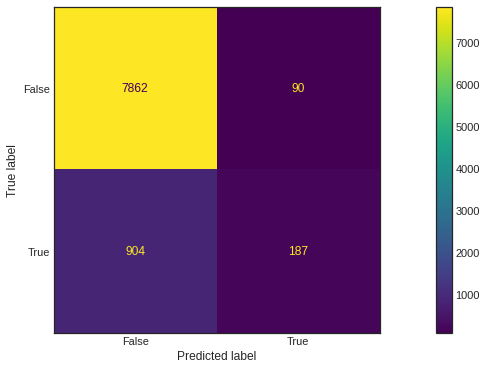

In [70]:
confusion_matrix_gen(actual,predicted)

Accuracy is not a correct performance metric for imbalanced datasets as in this case. Hence we will use some other performance metrics as below - 

In [71]:
# check performance
def check_performace(actual,predicted):

  import numpy as np
  import pandas as pd

  from sklearn.datasets import load_boston 
  from sklearn.linear_model import LogisticRegression
  from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
  from sklearn.model_selection import train_test_split
  from collections import Counter
  import matplotlib.pyplot as plt
  import seaborn as sns

  print('ROC-AUC score:',roc_auc_score(actual, predicted))
  print('Accuracy score:',accuracy_score(actual, predicted))
  print('F1 score:',f1_score(actual, predicted))

In [72]:
check_performace(actual,predicted)

ROC-AUC score: 0.5800422378450353
Accuracy score: 0.8900807254229791
F1 score: 0.2733918128654971


# **Handling Imbalanced Dataset - Random over-sampling with imblearn**


One way to fight imbalance data is to generate new samples in the minority classes. The most naive strategy is to generate new samples by randomly sampling with replacement of the currently available samples. The RandomOverSampler offers such a scheme.

In [73]:
# import library
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
# converting to array
X = np.array(df_bank_ready_preprocessed_train.iloc[:, :-1])
Y = np.array(df_bank_ready_preprocessed_train.iloc[:, -1])
# fit predictor and target varaible
x_ros, y_ros = ros.fit_resample(X,Y)

print('Original dataset shape', Counter(Y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 31970, 1: 4198})
Resample dataset shape Counter({0: 31970, 1: 31970})


In [74]:
# Applying Logistic Regression on the rebalanced data
# merging X and Y
import numpy as np
import pandas as pd

df_train_X = pd.DataFrame(x_ros, columns = ['housing_no', 'housing_yes', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'pdays',
       'age', 'balance', 'age'])
df_train_Y = pd.DataFrame(y_ros,columns =['Deposit'])
df_train_ros = pd.merge(left = df_train_X, right = df_train_Y,  left_index=True, right_index=True)


In [75]:
lr=LogisticRegression( train_df = df_train_ros , test_df = df_bank_ready_preprocessed_test,tolerance=0.0005,learningRate=0.0001,maxIteration=10000)
actual, predicted = lr.fit()

Solving using gradient descent


100%|██████████| 10000/10000 [02:25<00:00, 68.94it/s]

[ 1.07084597  0.22972281  1.31261955  0.83491336 -0.84696413  0.28661582
 -1.4945816   1.80612281 -0.63521512 -1.5353359  -1.29977315  0.00352087
  2.47345392 -0.57124036 -1.35064958  1.87835907  1.739292   -0.70167338
 -0.21387477  3.01172229 -0.79560535 -0.06205179 -0.76521669  0.06724038
 -0.76521669]
Evaluation for training data: 

Accuracy: 0.6149202377228652
Precision: 0.602095259267493
Recall: 0.6777291210509853

Evaluation for test data: 

Accuracy: 0.5749198274908769
Precision: 0.17420118343195265
Recall: 0.6746104491292392


In [76]:
# check performance
check_performace(actual,predicted)

ROC-AUC score: 0.6179264519288047
Accuracy score: 0.5749198274908769
F1 score: 0.27689992475545516


# **Handling Imbalanced Dataset - Synthetic minority over-sampling technique**

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

Saving SMOTE.png to SMOTE.png


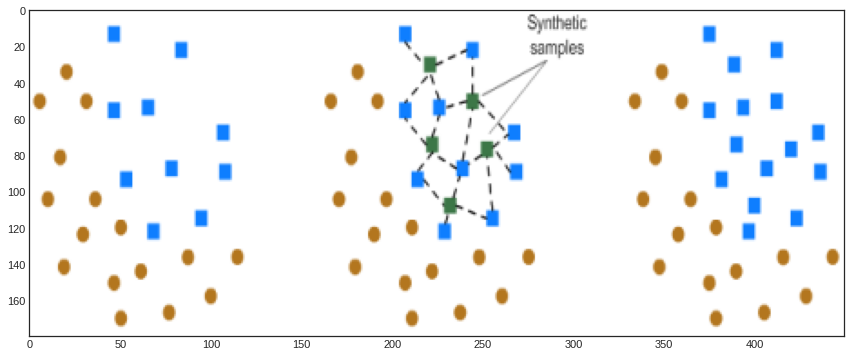

In [78]:
import cv2
tomek = files.upload()
img = cv2.imread('SMOTE.png')
dim = (450, 180)
img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
plt.imshow(img)

### SMOTE algorithm works in 4 simple steps:

1. Choose a minority class as the input vector
2. Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
3. Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
4. Repeat the steps until data is balanced

In [79]:
# load library
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=10)

# fit target and predictor variable
x_smote , y_smote = smote.fit_resample(X, Y)

print('Original dataset shape:', Counter(Y))
print('Resampled dataset shape:', Counter(y_smote))

Original dataset shape: Counter({0: 31970, 1: 4198})
Resampled dataset shape: Counter({0: 31970, 1: 31970})


In [80]:
# Applying Logistic Regression on the rebalanced data
# merging X and Y
import numpy as np
import pandas as pd

df_train_X = pd.DataFrame(x_smote, columns = ['housing_no', 'housing_yes', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'pdays',
       'age', 'balance', 'age'])
df_train_Y = pd.DataFrame(y_smote,columns =['Deposit'])
df_train_smote = pd.merge(left = df_train_X, right = df_train_Y,  left_index=True, right_index=True)


In [81]:
lr=LogisticRegression(train_df = df_train_smote , test_df = df_bank_ready_preprocessed_test,tolerance=0.0005,learningRate=0.0001,maxIteration=10000)
actual, predicted = lr.fit()

Solving using gradient descent


100%|██████████| 10000/10000 [02:23<00:00, 69.69it/s]

[ 0.95663425  0.10934891  1.35769145  0.64178293 -0.93349121  0.22048106
 -1.54074267  1.893919   -0.62021365 -1.89390471 -1.33465511  0.08463775
  2.4972139  -0.55430455 -1.36356691  1.90057732  1.77654174 -0.74759233
 -0.47151209  2.94236532 -0.65727774  0.03748896 -0.73998068  0.00951232
 -0.73998068]
Evaluation for training data: 

Accuracy: 0.624976540506725
Precision: 0.6113107675163671
Recall: 0.6863622145761652

Evaluation for test data: 

Accuracy: 0.5832135353311954
Precision: 0.17641372643789272
Recall: 0.6691109074243813


In [82]:
# check performance
check_performace(actual,predicted)

ROC-AUC score: 0.6202697394264763
Accuracy score: 0.5832135353311954
F1 score: 0.27921208644100215


## **Support Vector Machines**

In [94]:
from scipy import optimize
import seaborn as sns
class MaxMarginClassifier :
    def __init__(self, C):
        self.alpha = None
        self.w = None
        self.b = None
        self.supportVectors = None
        self.C = C
    
    
    def fit(self,X,y):
        N = len(y)
        Xy = X*y[:,np.newaxis]
        GramXy = np.matmul(Xy,Xy.T)
        
        def Ld0(G,alpha):
            obj_fun = alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))
            return obj_fun
        
        def partialDerivativeLd0(G, alpha):
            par_der = np.ones_like(alpha) - alpha.dot(G)
            return par_der
        
        alpha  = np.ones(N)
        A = np.vstack((-np.eye(N),np.eye(N)))
        b = np.concatenate((np.zeros(N),self.C*np.ones(N)))
        constraints = ({'type':'eq','fun':lambda a:np.dot(a,y),'jac':lambda a:y},
                       {'type':'ineq','fun':lambda a:b - np.dot(A,a), 'jac':lambda a:-A})
        optRes = optimize.minimize(fun = lambda a:-Ld0(GramXy,a),x0 = alpha, method = 'SLSQP',
                                   jac = lambda a:-partialDerivativeLd0(GramXy,a),
                                   constraints = constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:,np.newaxis]*Xy),axis = 0)
        epsilon = 1e-4
        self.supportVectors = X[self.alpha > epsilon]
        self.supportLabels = y[self.alpha > epsilon]
        b = []
        for i in range(len(self.supportLabels)):
                      b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T,self.w)
                      b.append(b_i)
        self.b = sum(b)/len(b)
            
    
    def predict(self,X):
                      
                      return 2*(np.matmul(X,self.w)+self.b > 0) - 1
        

In [95]:
svm_model = MaxMarginClassifier(C = 5)

In [88]:
df_SVM_Y_test = df_bank_ready_preprocessed_train.iloc[:,-1]

In [89]:
df_SVM_Y_test = df_SVM_Y_test.replace(0,-1)

In [90]:
df_SVM_X_test = df_bank_ready_preprocessed_train.iloc[:,:-1]

In [ ]:
svm_model.fit(df_SVM_X_test.sample(frac=0.05, replace=True, random_state=1),df_SVM_Y_test.sample(frac=0.05, replace=True, random_state=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  from ipykernel import kernelapp as app


# **Naive Bayes**